# Square-root Kalman filter for online learning

In [1]:
import jax
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from jax.flatten_util import ravel_pytree
import flax.linen as nn

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 15
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rc("text", usetex=True)

In [3]:
sns.set_palette("colorblind")
palette = sns.color_palette()

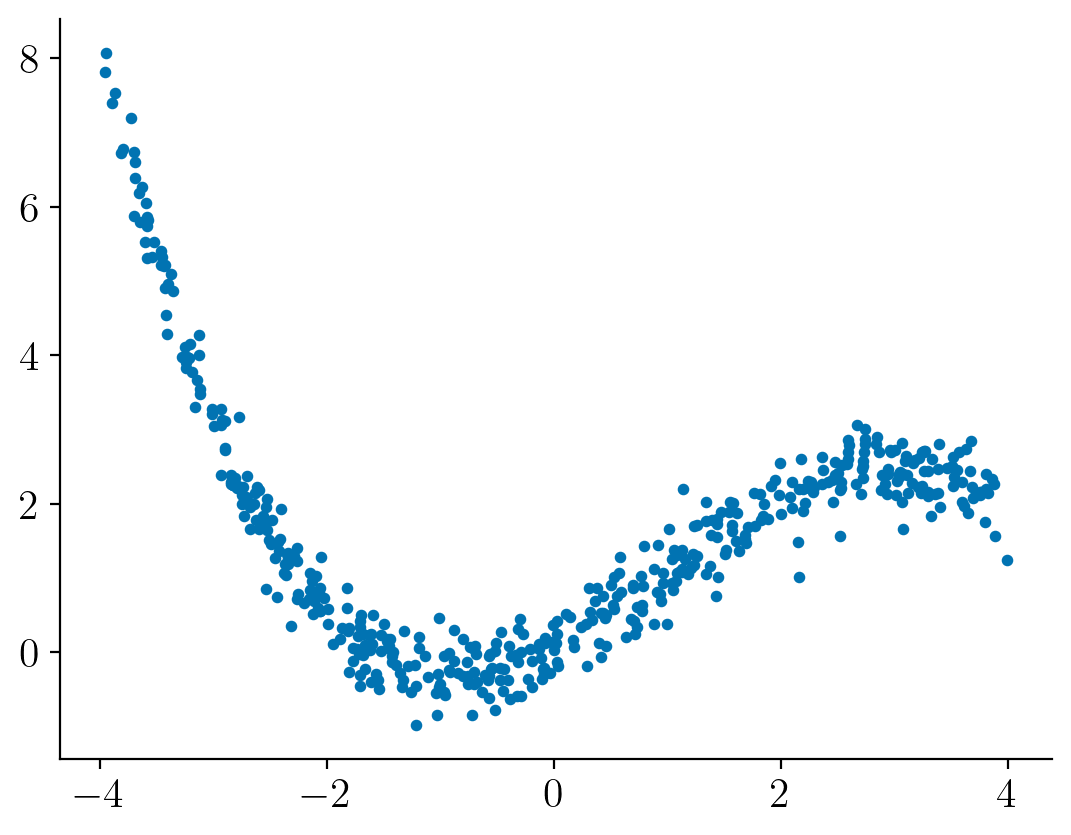

In [4]:
key = jax.random.PRNGKey(314)
key_data, key_filter = jax.random.split(key)
key_x, key_y, key_coef, key_samples = jax.random.split(key_data, 4)
m = 1
n_test = 200
n_samples = 300 + n_test

# coefs = jax.random.uniform(key_coef, shape=(m,) ,minval=-3, maxval=3)
coefs = jnp.array([0.1, 0.8, 0.3, -0.1])
xmin, xmax = -4, 4
X = jax.random.uniform(key_x, (n_samples, m)) * (xmax - xmin) + xmin
Phi = jnp.c_[X ** 0, X ** 1, X ** 2, X** 3]

errs = jax.random.normal(key_y, (n_samples,)) * 0.3
y = jnp.einsum("sm,m->s", Phi, coefs) + errs
y = jnp.atleast_2d(y).T
plt.scatter(X, y, s=10)

## Kalman filter

### Predict step
$$
\begin{aligned}
    \mu_{t|t-1} &= {\bf F}_t\,\mu_{t-1}\\
    \Sigma_{t|t-1} &= {\bf F}_t\,\Sigma_{t-1}\,{\bf F}_t^\intercal + Q_t
\end{aligned}
$$

### Innovation and Gain
$$
\begin{aligned}
    \hat y_t &= {\bf H}_t\,\mu_{t|t-1}\\
    {\bf S}_t &= {\bf H}_t\,\Sigma_{t|t-1}\,{\bf H}_t^\intercal + R_t\\
    {\bf K}_t &= \Sigma_{t|t-1}\,{\bf H}_t^\intercal\,{\bf S}_t^{-1}
\end{aligned}
$$


### Update
$$
\begin{aligned}
\mu_t &= \mu_{t|t-1} + {\bf K}_t(y_t - \hat{y}_t)\\
\Sigma_t &=
\left[{\bf I} - {\bf K}_t\,{\bf H}_t\right]\,\Sigma_{t|t-1}\left[{\bf I} - {\bf K}_t\,{\bf H}_t\right]^\intercal
+ {\bf K}_t\,R_t\,{\bf K}_t^{\intercal}\\
\end{aligned}
$$

In [5]:
_, D = Phi.shape
mu_init = jnp.zeros(D)
Sigma_init = jnp.eye(D)

In [6]:
Rt = 0.3 ** 2 * jnp.eye(1)
Qt = jnp.eye(D) * 0.0

In [7]:
def step(state, obs):
    mu, Sigma = state
    X, y = obs
    X = X[:, None]
    I = jnp.eye(len(X))

    Sigma = Sigma + Qt

    yhat = X.T @ mu
    St = X.T  @ Sigma @ X + Rt
    Kt = jnp.linalg.solve(St, X.T @ Sigma).T

    mu = mu + Kt @ (y - yhat)
    cst = I - Kt @ X.T
    Sigma = cst @ Sigma @ cst.T + Kt @ Rt @ Kt.T
    # Sigma = Sigma - Kt @ St @ Kt.T
    return (mu, Sigma), yhat

In [8]:
%%time
dataset = (Phi, y)
bel_init = (mu_init, Sigma_init)
(mu_final, Sigma_final), yhat_hist = jax.lax.scan(step, bel_init, dataset)

CPU times: user 64.5 ms, sys: 5.99 ms, total: 70.5 ms
Wall time: 72.8 ms


In [9]:
yhat_final = jnp.einsum("sm,m->s", Phi, mu_final)

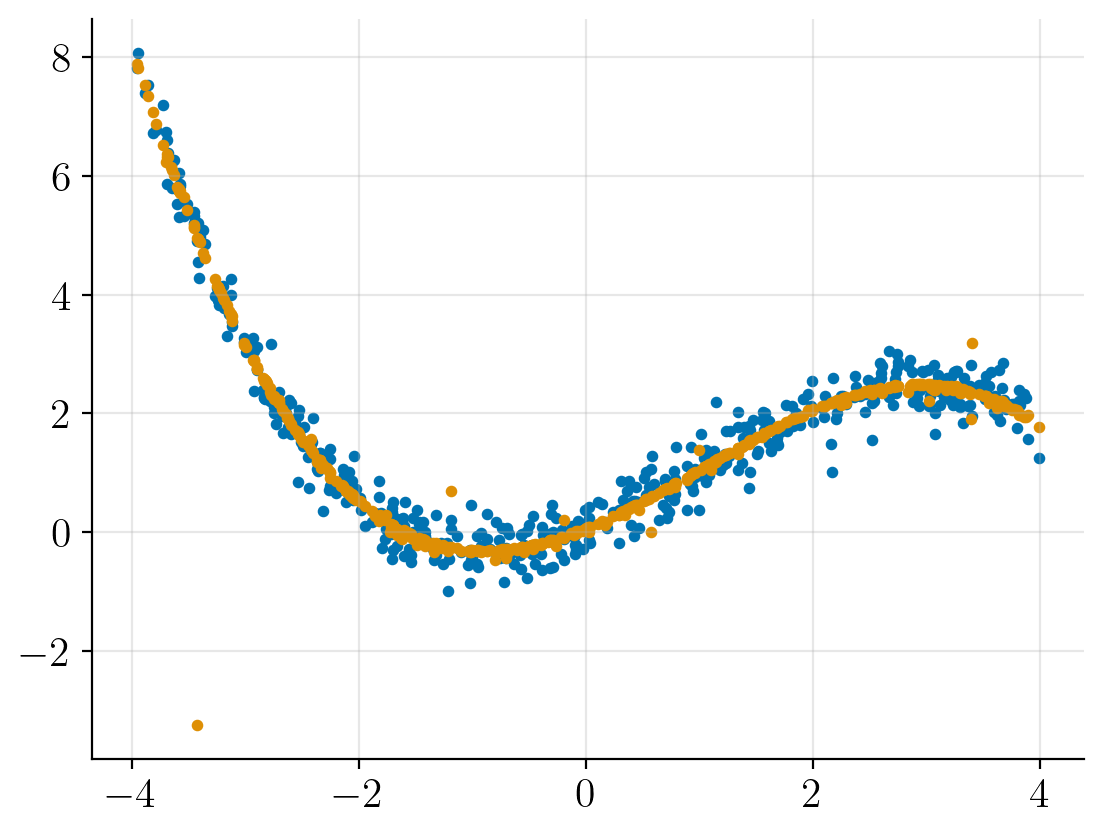

In [10]:
plt.scatter(X, y, s=10)
plt.scatter(X, yhat_hist, s=10)
plt.grid(alpha=0.3)

## Squared-root Kalman filter

In [11]:
xt = Phi[-1, None]

In [12]:
W_final = jnp.linalg.cholesky(Sigma_final, upper=True)

In [13]:
W_final.T @ W_final

Array([[ 4.1674159e-04,  1.4623893e-05, -4.5982593e-05, -9.2564807e-07],
       [ 1.4623893e-05,  2.2519467e-04,  1.8667360e-07, -2.0987605e-05],
       [-4.5982593e-05,  1.8667360e-07,  8.9736086e-06, -1.3416830e-07],
       [-9.2564807e-07, -2.0987605e-05, -1.3416830e-07,  2.3183002e-06]],      dtype=float32)

In [14]:
Sigma_final

Array([[ 4.1674159e-04,  1.4623944e-05, -4.5982571e-05, -9.2564977e-07],
       [ 1.4623842e-05,  2.2519467e-04,  1.8667356e-07, -2.0987600e-05],
       [-4.5982622e-05,  1.8667377e-07,  8.9736086e-06, -1.3416815e-07],
       [-9.2564636e-07, -2.0987614e-05, -1.3416842e-07,  2.3183002e-06]],      dtype=float32)

### Innovation

$$
\begin{aligned}
    S_t
    &= H_t\Sigma_{t|t-1}H_t^\intercal + R_t\\
    &= H_t W_{t|t-1}^\intercal W_{t|t-1} H_t^\intercal + R_t^{\intercal/2}\,R_t^{1/2}\\
    &=
    \begin{bmatrix}
        H_t W_{t|t-1}^\intercal & R_t^{\intercal/2}
    \end{bmatrix}
    \begin{bmatrix}
    W_{t|t-1}H_t^\intercal\\
    R_t^{1/2}
    \end{bmatrix}
\end{aligned}
$$

In [15]:
Rt_half = jnp.linalg.cholesky(Rt, upper=True)

In [16]:
W_final @ Phi[-1, None].T

Array([[-0.01190079],
       [-0.01807389],
       [ 0.02657686],
       [ 0.03298563]], dtype=float32)

In [17]:
part = jnp.r_[W_final @ xt.T, Rt_half]
S_half = jnp.linalg.qr(part, mode="r") # Squared-root of innovation
S_half @ S_half.T

Array([[0.09226269]], dtype=float32)

In [18]:
S = Phi[-1].T @ Sigma_final @ Phi[-1] + Rt
S

Array([[0.09226268]], dtype=float32)

### Kalman gain

$$
\begin{aligned}
    K_t
    &= \Sigma_{t|t-1}\,H_t^\intercal\,S_t^{-1}\\
    &= \left(S_t^{-1}\,H_t\Sigma_{t|t-1}\right)^\intercal\\
    &= \left(S_t^{-1/2}S_t^{-\intercal/2}\,H_t\,W_{t|t-1}^\intercal W_{t|t-1}\right)^\intercal
\end{aligned}
$$

In [19]:
Sigma_final @ xt.T @ jnp.linalg.inv(S) # Kalman gain-full

Array([[-0.00263319],
       [-0.00302876],
       [ 0.00083483],
       [ 0.00048442]], dtype=float32)

In [20]:
Kt = jnp.linalg.solve(S_half, jnp.linalg.solve(S_half.T, xt) @ W_final.T @ W_final).T
Kt

Array([[-0.00263319],
       [-0.00302876],
       [ 0.00083483],
       [ 0.00048442]], dtype=float32)

### Update

$$
\begin{aligned}
\Sigma_t &=
\left[{\bf I} - {\bf K}_t\,{\bf H}_t\right]\,\Sigma_{t|t-1}\left[{\bf I} - {\bf K}_t\,{\bf H}_t\right]^\intercal
+ {\bf K}_t\,R_t\,{\bf K}_t^{\intercal}\\
&= \left[{\bf I} - {\bf K}_t\,{\bf H}_t\right]\,W_{t|t-1}^\intercal W_{t|t-1}\left[{\bf I} - {\bf K}_t\,{\bf H}_t\right]^\intercal
+ {\bf K}_t\,R_t^{\intercal/2}R_t^{1/2}\,{\bf K}_t^{\intercal}\\
&= 
\begin{bmatrix} \left[{\bf I} - {\bf K}_t\,{\bf H}_t\right]\,W_{t|t-1}^\intercal & {\bf K}_t\,R_t^{\intercal/2} \end{bmatrix}
\begin{bmatrix}
W_{t|t-1}\left[{\bf I} - {\bf K}_t\,{\bf H}_t\right]^\intercal\\
R_t^{1/2}\,{\bf K}_t^{\intercal}
\end{bmatrix}
\end{aligned}
$$

In [21]:
jnp.set_printoptions(precision=6)

In [22]:
I = jnp.eye(D)
part = jnp.r_[(I - Kt @ xt) @ W_final.T, Rt_half @ Kt.T]
W_update = jnp.linalg.qr(part, mode="r")

In [23]:
W_update.T @ W_update

Array([[ 4.215807e-04,  9.659747e-06, -3.085449e-06,  1.762194e-06],
       [ 9.659747e-06,  2.258195e-04,  1.300846e-06,  5.400611e-07],
       [-3.085449e-06,  1.300846e-06,  3.874925e-06, -3.096319e-08],
       [ 1.762194e-06,  5.400611e-07, -3.096319e-08,  3.811082e-07]],      dtype=float32)

In [24]:
cst = I - Kt @ xt
cst @ Sigma_final @ cst.T + Kt @ Rt @ Kt.T

Array([[ 4.161019e-04,  1.388812e-05, -4.577975e-05, -8.079627e-07],
       [ 1.388802e-05,  2.243483e-04,  4.199583e-07, -2.085223e-05],
       [-4.577981e-05,  4.199590e-07,  8.909308e-06, -1.714796e-07],
       [-8.079591e-07, -2.085225e-05, -1.714798e-07,  2.296650e-06]],      dtype=float32)

### Implementation

In [25]:
Rt = 0.3 ** 2 * jnp.eye(1)
Rt_half = jnp.linalg.cholesky(Rt, upper=True)

In [26]:
def step(state, obs):
    mu, W = state
    X, y = obs
    I = jnp.eye(len(X))
    
    X = X[:, None]

    # Predict
    yhat = X.T @ mu

    # Innovation update
    part = jnp.r_[W @ X, Rt_half]
    S_half = jnp.linalg.qr(part, mode="r") # Squared-root of innovation

    # Kalman gain
    Kt = jnp.linalg.solve(S_half, jnp.linalg.solve(S_half.T, X.T) @ W.T @ W).T

    # Upate
    mu = mu + Kt @ (y - yhat)
    part = jnp.r_[W @ (I - Kt @ X.T).T, Rt_half @ Kt.T]
    W = jnp.linalg.qr(part, mode="r").real

    return (mu, W), yhat

In [30]:
_, D = Phi.shape
mu_init = jnp.zeros(D)
W_init = jnp.linalg.cholesky(jnp.eye(D))

In [31]:
%%time
dataset = (Phi, y)
bel_init = (mu_init, W_init)
(mu_final_sqr, W_final), yhat_hist = jax.lax.scan(step, bel_init, dataset)

CPU times: user 113 ms, sys: 10.7 ms, total: 124 ms
Wall time: 117 ms


In [32]:
W_final

Array([[ 2.041425e-02,  7.163613e-04, -2.252482e-03, -4.534311e-05],
       [ 0.000000e+00,  1.498939e-02,  1.201018e-04, -1.397999e-03],
       [ 0.000000e+00,  0.000000e+00,  1.971176e-03, -3.470094e-05],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  6.005296e-04]],      dtype=float32)

In [33]:
yhat_final = jnp.einsum("sm,m->s", Phi, mu_final)

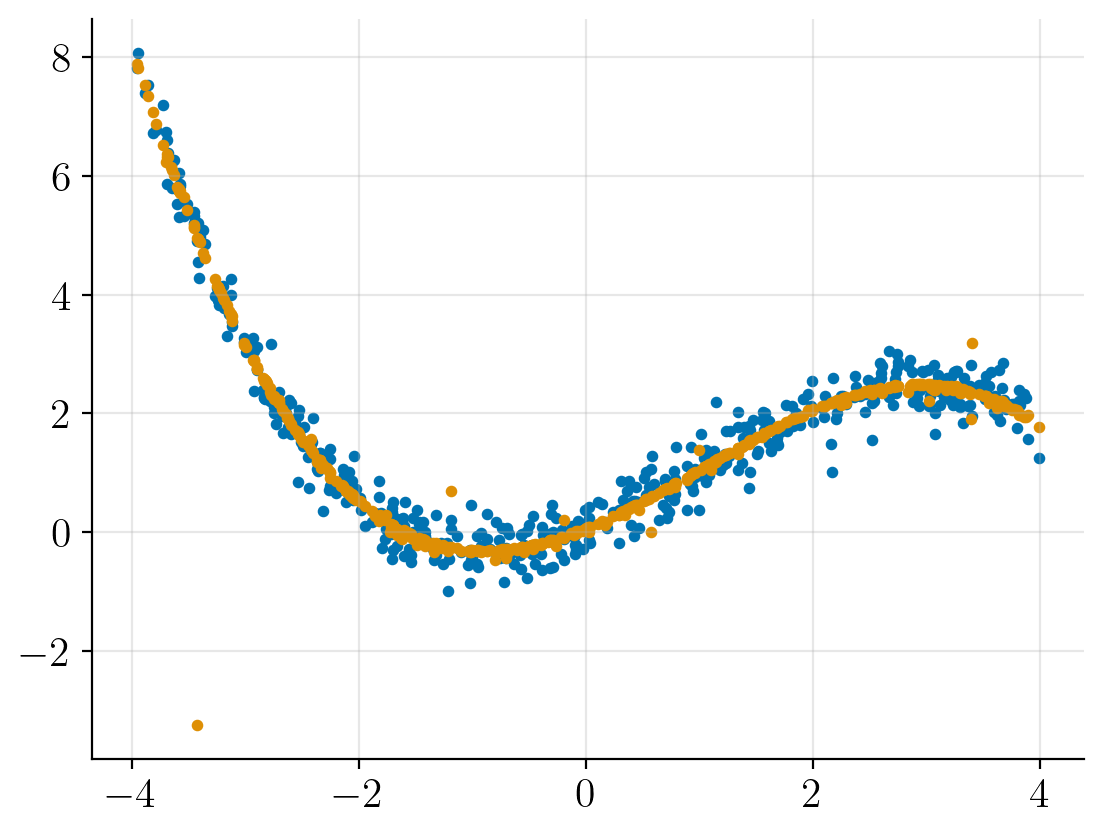

In [34]:
plt.scatter(X, y, s=10)
plt.scatter(X, yhat_hist, s=10)
plt.grid(alpha=0.3)

## Comparing full and squared-root

## mean

In [35]:
mu_final

Array([ 0.078615,  0.772779,  0.304828, -0.097675], dtype=float32)

In [36]:
mu_final_sqr

Array([ 0.078615,  0.772779,  0.304827, -0.097675], dtype=float32)

### Covariance

In [37]:
Sigma_final

Array([[ 4.167416e-04,  1.462394e-05, -4.598257e-05, -9.256498e-07],
       [ 1.462384e-05,  2.251947e-04,  1.866736e-07, -2.098760e-05],
       [-4.598262e-05,  1.866738e-07,  8.973609e-06, -1.341681e-07],
       [-9.256464e-07, -2.098761e-05, -1.341684e-07,  2.318300e-06]],      dtype=float32)

In [38]:
W_final.T @ W_final

Array([[ 4.167416e-04,  1.462398e-05, -4.598273e-05, -9.256456e-07],
       [ 1.462398e-05,  2.251950e-04,  1.866625e-07, -2.098764e-05],
       [-4.598273e-05,  1.866625e-07,  8.973634e-06, -1.341694e-07],
       [-9.256456e-07, -2.098764e-05, -1.341694e-07,  2.318298e-06]],      dtype=float32)

## References

* Tracy, Kevin. "A square-root kalman filter using only qr decompositions." arXiv preprint arXiv:2208.06452 (2022).